In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from rasterstats import zonal_stats
import rasterio

# Data Preperation

In [10]:
#Load pre-existing park data
parks_gdf = gpd.read_file('Data/Riyadh_parks_stats_2024.geojson')
print("Loaded parks_gdf with columns:", parks_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean', 'vegetation_prop',
       'bare_sparse_prop', 'impervious_prop', 'park_id', 'geometry'],
      dtype='object')


In [11]:
# Define LST file path
lst_2024_path = 'Data/Raster/Riyadh_LST_EPSG20438_2024.tif' 

In [12]:
# Open LST raster to access pixel values and transformation parameters.
with rasterio.open(lst_2024_path) as lst_src:
    lst_transform = lst_src.transform
    lst_crs = lst_src.crs
    lst_data = lst_src.read(1)
#    print(np.nanmin(lst_data), np.nanmax(lst_data))

## 1. Buffer Creation

For each park, createt buffers at 30m intervals up to 300m for the comparison of LST across different zones, providing insights into the urban heat island effect and park cooling influence. ([Cai et al., 2023](https://www.researchgate.net/publication/374556563_Cooling_island_effect_in_urban_parks_from_the_perspective_of_internal_park_landscape); [Zhang et al., 2024](https://www.nature.com/articles/s41598-024-67277-2))


In [13]:
# 2. Generate Buffers (30m intervals up to 600m)
buffer_distances = range(30, 601, 30)  # [30, 60, 90,..., 600]

# Initialize GeoDataFrame with proper CRS
buffer_gdf = gpd.GeoDataFrame(columns=['park_id', 'distance', 'geometry'], crs=parks_gdf.crs)

for park_id, park in parks_gdf.iterrows():
    for dist in buffer_distances:
        # Create donut-shaped buffers (outer - inner)
        outer = park.geometry.buffer(dist)
        inner = park.geometry.buffer(max(0, dist-30))  # Handle 0-30m case
        ring = outer.difference(inner)
        
        # Append to GeoDataFrame
        buffer_gdf = pd.concat([
            buffer_gdf,
            gpd.GeoDataFrame({
                'park_id': [park_id],
                'distance': [dist],
                'geometry': [ring]
            }, crs=parks_gdf.crs)
        ], ignore_index=True)


In [14]:
# Verify the output structure
print(f"Generated {len(buffer_gdf)} buffer rings")
print("GeoDataFrame columns:", buffer_gdf.columns)
print("CRS:", buffer_gdf.crs)
print("Sample data:")
print(buffer_gdf.head(3))

Generated 4420 buffer rings
GeoDataFrame columns: Index(['park_id', 'distance', 'geometry'], dtype='object')
CRS: EPSG:20438
Sample data:
  park_id distance                                           geometry
0       0       30  POLYGON ((678371.261 2735243.793, 678368.638 2...
1       0       60  POLYGON ((678387.297 2735218.438, 678382.05 27...
2       0       90  POLYGON ((678403.333 2735193.084, 678395.463 2...


In [ ]:
# Save to GeoJSON
buffer_gdf.to_file('Data/Riyadh_parks_buffers.geojson', driver='GeoJSON')
print("Saved buffers to GeoJSON")

## 2. LST Calculation

In [15]:
# Calculate LST Statistics for park interiors and concentric buffer zones around each park (30-600m in 30m intervals)

# Initialize buffer stats columns in parks_gdf
for dist in range(30, 601, 30): # 601 ensures up to 600m buffer
    parks_gdf[f'lst_buffer_{dist}m'] = np.nan  # Initialize all buffer columns

with rasterio.open(lst_2024_path) as src:

    raster_nodata = src.nodata if src.nodata is not None else -999
    print(f"Processing LST raster with nodata value: {raster_nodata}")
    
    # Calculate mean LST for park interiors
    park_stats = zonal_stats(
        parks_gdf,
        lst_2024_path,
        stats=['mean'],
        nodata=raster_nodata, 
        geojson_out=False # Returns lightweight dictionaries instead of full GeoJSON features
    )
    parks_gdf['lst_park'] = [x['mean'] for x in park_stats]
    
    
    # Calculate mean LST for each buffer zone
    buffer_stats = zonal_stats(
        buffer_gdf,
        lst_2024_path,
        stats=['mean'],
        nodata= raster_nodata,
        geojson_out=False  # Returns lightweight dictionaries instead of full GeoJSON features
    )
    buffer_gdf['lst_mean'] = [x['mean'] for x in buffer_stats]
    
    # Populate buffer stats back into parks_gdf
    for park_id in parks_gdf.index:
        park_buffers = buffer_gdf[buffer_gdf['park_id'] == park_id]
        # Assign LST values to corresponding columns
        for _, buffer in park_buffers.iterrows():
            dist = buffer['distance']
            lst_value = buffer['lst_mean']
            
            # Only update if we got a valid value (not nodata)
            if lst_value is not None and not np.isnan(lst_value):
                parks_gdf.at[park_id, f'lst_buffer_{dist}m'] = lst_value
            else:
                print(f"Warning: No valid LST data for park {park_id} at {dist}m buffer")

# Data Quality Check

print("\nData Quality Summary:")
print(f"- Parks processed: {len(parks_gdf)}")
print(f"- Buffer zones processed: {len(buffer_gdf)}")


Processing LST raster with nodata value: -999

Data Quality Summary:
- Parks processed: 221
- Buffer zones processed: 4420


In [16]:
# Preview results
print(parks_gdf[[
    'park_id', 'lst_park', 
    'lst_buffer_30m', 'lst_buffer_60m', 
    'lst_buffer_90m', 'lst_buffer_120m'
]].head())

   park_id   lst_park  lst_buffer_30m  lst_buffer_60m  lst_buffer_90m  \
0        1  49.692844       50.002060       50.250832       50.385091   
1        2  50.194718       50.308374       50.213587       50.215840   
2        3  49.864762       49.935038       50.186160       50.445667   
3        4  51.297740       51.185881       50.987837       50.683858   
4        5  49.920562       49.988923       50.112948       50.310376   

   lst_buffer_120m  
0        50.429612  
1        50.132221  
2        50.605099  
3        50.556463  
4        50.484693  


In [17]:
# Commented out exports:
parks_gdf.to_file('Data/Riyadh_parks_with_LST.geojson', driver='GeoJSON')


In [18]:
# Calculate cooling effects (ΔT between buffers and park interior)
for dist in range(30, 601, 30):
    parks_gdf[f'cooling_{dist}m'] = (
        parks_gdf[f'lst_buffer_{dist}m'] - parks_gdf['lst_park']
    )




Sample Results (first 3 parks):
   park_id   lst_park  lst_buffer_30m  lst_buffer_60m  lst_buffer_90m  \
0        1  49.692844       50.002060       50.250832       50.385091   
1        2  50.194718       50.308374       50.213587       50.215840   
2        3  49.864762       49.935038       50.186160       50.445667   

   lst_buffer_120m  
0        50.429612  
1        50.132221  
2        50.605099  


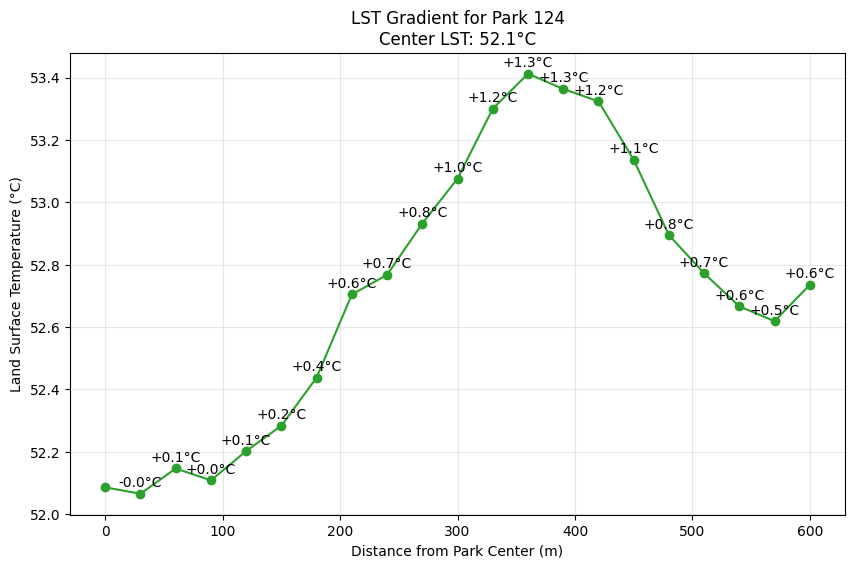

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Select a random park (or specific park by index)
sample_park = parks_gdf.sample(1).iloc[0]  # Random selection
# sample_park = parks_gdf.iloc[3]  # Or select specific park

# Prepare data
distances = np.arange(30, 601, 30)  # 30, 60, ..., 600
lst_values = [sample_park['lst_park']] + [sample_park[f'lst_buffer_{d}m'] for d in distances]
distances_with_center = [0] + list(distances)  # Include center point (0m)

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(distances_with_center, lst_values, marker='o', linestyle='-', color='#2ca02c')

# Formatting
plt.title(f"LST Gradient for Park {sample_park['park_id']}\n"
          f"Center LST: {sample_park['lst_park']:.1f}°C")
plt.xlabel('Distance from Park Center (m)')
plt.ylabel('Land Surface Temperature (°C)')
plt.grid(True, alpha=0.3)

# Annotate cooling effect
for d, lst in zip(distances, lst_values[1:]):
    cooling = lst - sample_park['lst_park']
    plt.annotate(f'{cooling:+.1f}°C', 
                (d, lst), 
                textcoords="offset points",
                xytext=(0,5), 
                ha='center')

plt.show()